In [103]:
%matplotlib inline
%qtconsole
import numpy as np
import pandas as pd
import xgboost
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.grid_search import GridSearchCV


In [2]:
df = pd.read_csv('ukretail_dataset.csv', index_col=0)

In [3]:
df.head()

CustomerID  average_order_value  number_orders  total_order_value  \
1     12347.0           351.604286              7            2461.23   
2     12348.0           250.370000              4            1001.48   
3     12349.0          1141.640000              1            1141.64   
4     12350.0           185.500000              1             185.50   
5     12352.0           220.830000              8            1766.64   

   cohort2010.12.01  cohort2011.01.01  cohort2011.02.01  cohort2011.03.01  \
1                 1                 0                 0                 0   
2                 1                 0                 0                 0   
3                 0                 0                 0                 0   
4                 0                 0                 1                 0   
5                 0                 0                 1                 0   

   cohort2011.04.01  cohort2011.05.01          ...           \
1                 0                 0          ...            
2                 0                 0          ...            
3                 0                 0          ...            
4                 0                 0          ...            
5                 0                 0          ...            

   CountrySaudi.Arabia  CountrySingapore  CountrySpain  CountrySweden  \
1                    0                 0             0              0   
2                    0                 0             0              0   
3                    0                 0             0              0   
4                    0                 0             0              0   
5                    0                 0             0              0   

   CountrySwitzerland  CountryUnited.Arab.Emirates  CountryUnited.Kingdom  \
1                   0                            0                      0   
2                   0                            0                      0   
3                   0                            0                      0   
4                   0                            0                      0   
5                   0                            0                      0   

   CountryUnspecified  CountryUSA  top.selling.purchase  
1                   0           0                   103  
2                   0           0                    19  
3                   0           0                    45  
4                   0           0                     9  
5                   0           0                    58  

[5 rows x 64 columns]

### Split data

In [89]:
#y = np.log(df.order_sequence_1+1)
y = df.order_sequence_1
X = df.drop(['order_sequence_1','CustomerID'], axis=1)
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.33, random_state=99)

In [90]:
print(y.shape)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(4292,)
(2875, 62)
(2875,)
(1417, 62)
(1417,)


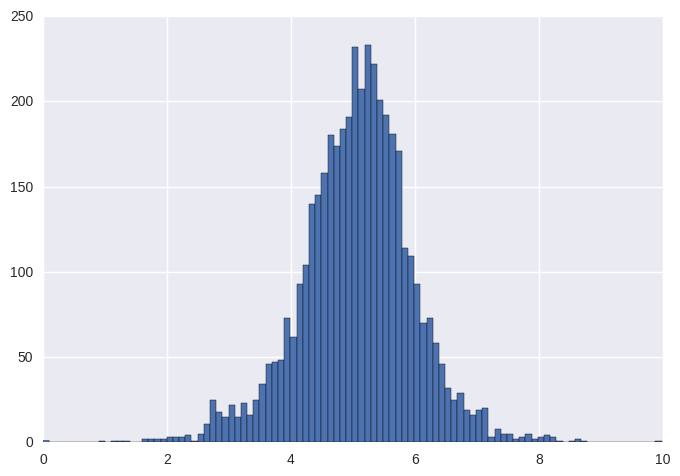

In [6]:
y.hist(bins=100)

In [91]:
params = {
 'max_depth':[9],
'min_child_weight':[5],
     'learning_rate' :[0.1],
    'gamma':[0.0]
}

def cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=5):
    gs = GridSearchCV(clf, param_grid=params, cv=n_folds, n_jobs=-1)
    gs.fit(Xtrain, ytrain)
    
    return gs.best_estimator_  

In [92]:
clf = xgboost.XGBRegressor()

best_clf = cv_optimize(clf,param_test1,X_train,y_train)


In [93]:
print(best_clf)
best_clf.score(X_test,y_test)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0.0, learning_rate=0.1, max_delta_step=0, max_depth=9,
       min_child_weight=5, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)


0.80694298958203992

In [94]:
features_weights = pd.DataFrame.from_dict(best_clf.booster().get_fscore(),orient="index")
features_weights.columns = ['weight']


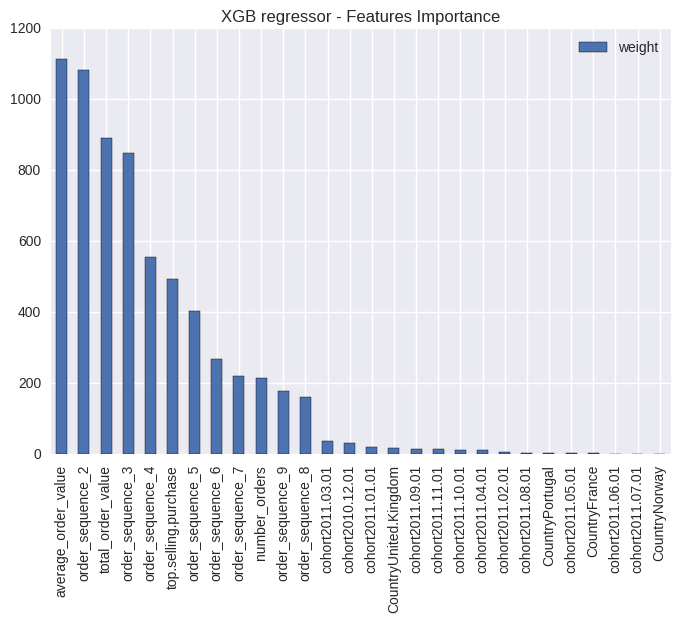

In [95]:
features_weights.sort_values(by='weight',ascending=False).plot(kind='bar',title='XGB regressor - Features Importance')

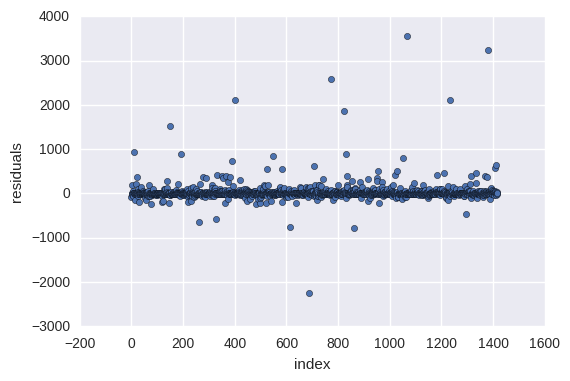

In [113]:
predictions = np.expm1(best_clf.predict(X_test))
df_prediction = pd.DataFrame({'predicted': predictions})
df_prediction['observed']= np.expm1(y_test.values)
df_prediction['residuals']= df_prediction.observed-df_prediction.predicted
df_prediction = df_prediction.reset_index()
df_prediction.plot.scatter(x="index",y="residuals")